In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from sklearn import svm, cross_validation
import pylab as pl
from PIL import Image
import numpy as np
import os
import time
# Make sure that caffe is on the python path:
caffe_root = '/u/zexuan/caffe/caffe/'  # this file is expected to be in {caffe_root}/examples
caffe_real_root = '/pkgs/caffe/'
thesis_root = '/ais/gobi2/pingpong/thesis/'
#!ls /pkgs/caffe
import sys
sys.path.insert(0, caffe_real_root + 'python')
import caffe

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Download the caffenet model to models/bvlc_reference_caffenet directory
!/u/zexuan/caffe/caffe/data/ilsvrc12/get_ilsvrc_aux.sh
if not os.path.isfile('/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !~/caffe/caffe/scripts/download_model_binary.py ~/caffe/caffe/models/bvlc_reference_caffenet

/h/14/zexuan/caffe/caffe/data/ilsvrc12
Downloading...
--2016-04-19 23:39:13--  http://dl.caffe.berkeleyvision.org/caffe_ilsvrc12.tar.gz
Resolving dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)... 169.229.222.251
Connecting to dl.caffe.berkeleyvision.org (dl.caffe.berkeleyvision.org)|169.229.222.251|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17858008 (17M) [application/octet-stream]
Saving to: ‘caffe_ilsvrc12.tar.gz’

100%[======================================>] 17,858,008  10.1MB/s   in 1.7s   

2016-04-19 23:39:15 (10.1 MB/s) - ‘caffe_ilsvrc12.tar.gz’ saved [17858008/17858008]

Unzipping...
Done.


In [3]:
# Download training data into data/flickr_style directory and labels into train.txt and test.txt
!python ~/caffe/caffe/examples/finetune_flickr_style/assemble_data.py \
    --workers=-1 --images=2000 --seed=1701 --label=5

Writing train/val for 2000 successfully downloaded images.


In [4]:
#For your record, if you want to train the network in pure C++ tools, here is the command:
# build/tools/caffe train \
#     -solver models/finetune_flickr_style/solver.prototxt \
#     -weights models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel \
#     -gpu 0

niter = 2000
# losses will also be stored in the log
train_loss = np.zeros(niter)
scratch_train_loss = np.zeros(niter)

caffe.set_device(0)
caffe.set_mode_gpu()
#caffe.set_mode_cpu()


In [5]:
start_time = time.time()
#solver = caffe.SGDSolver('/u/zexuan/caffe/caffe/models/finetune_flickr_style/solver.prototxt')
solver = caffe.SGDSolver('/u/zexuan/caffe/caffe/models/finetune_stroke_cls/solver.prototxt')
solver.net.copy_from('/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
# For reference, we also create a solver that does no finetuning.
#scratch_solver = caffe.SGDSolver('/u/zexuan/caffe/caffe/models/finetune_flickr_style/solver.prototxt')
scratch_solver = caffe.SGDSolver('/u/zexuan/caffe/caffe/models/finetune_stroke_cls/solver.prototxt')

# We run the solver for niter times, and record the training loss.

for it in range(niter):
    solver.step(1)  # SGD by Caffe
    scratch_solver.step(1)
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    scratch_train_loss[it] = scratch_solver.net.blobs['loss'].data
    if it % 5 == 0:
        print 'iter %d, finetune_loss=%f, scratch_loss=%f' % (it, train_loss[it], scratch_train_loss[it])
        
        test_iters = 10
        accuracy = 0
        scratch_accuracy = 0
        for it in np.arange(test_iters):
            solver.test_nets[0].forward()
            #solver.net.forward()
            accuracy += solver.test_nets[0].blobs['accuracy'].data
            scratch_solver.test_nets[0].forward()
            #scratch_solver.net.forward()
            scratch_accuracy += scratch_solver.test_nets[0].blobs['accuracy'].data
        accuracy /= test_iters
        scratch_accuracy /= test_iters
        print '\tAccuracy for fine-tuning:', accuracy
        print '\tAccuracy for training from scratch:', scratch_accuracy

print 'Finish with total time: %g seconds'%(time.time()-start_time)

iter 0, finetune_loss=3.325465, scratch_loss=3.537368
	Accuracy for fine-tuning: 0.31400000453
	Accuracy for training from scratch: 0.257999996841
iter 5, finetune_loss=3.427015, scratch_loss=25.487217
	Accuracy for fine-tuning: 0.0529999991879
	Accuracy for training from scratch: 0.0769999999553
iter 10, finetune_loss=2.374142, scratch_loss=7.607032
	Accuracy for fine-tuning: 0.147999999672
	Accuracy for training from scratch: 0.107999999449
iter 15, finetune_loss=2.096251, scratch_loss=2.923349
	Accuracy for fine-tuning: 0.218000000715
	Accuracy for training from scratch: 0.0499999994412
iter 20, finetune_loss=2.084082, scratch_loss=2.816509
	Accuracy for fine-tuning: 0.185000002384
	Accuracy for training from scratch: 0.176000002027
iter 25, finetune_loss=1.894195, scratch_loss=2.477635
	Accuracy for fine-tuning: 0.401000002027
	Accuracy for training from scratch: 0.173999999464
iter 30, finetune_loss=1.781072, scratch_loss=2.535767
	Accuracy for fine-tuning: 0.303000003099
	Accurac

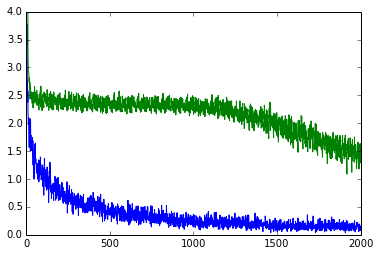

In [6]:
pl.plot(np.vstack([train_loss, scratch_train_loss]).clip(0, 4).T)

In [7]:
test_iters = 10
accuracy = 0
scratch_accuracy = 0
for it in np.arange(test_iters):
    solver.test_nets[0].forward()
    #solver.net.forward()
    accuracy += solver.test_nets[0].blobs['accuracy'].data
    scratch_solver.test_nets[0].forward()
    #scratch_solver.net.forward()
    scratch_accuracy += scratch_solver.test_nets[0].blobs['accuracy'].data
accuracy /= test_iters
scratch_accuracy /= test_iters
print 'Accuracy for fine-tuning:', accuracy
print 'Accuracy for training from scratch:', scratch_accuracy

Accuracy for fine-tuning: 0.637999999523
Accuracy for training from scratch: 0.431000000238


In [9]:
#dir(solver.test_nets[1])
solver.net.save('fine_tune_stroke_cls_2000iter.caffemodel')
solver.test_nets[0].save('fine_tune_stroke_cls_testnet_2000iter.caffemodel')
scratch_solver.net.save('fine_tune_stroke_cls_scratch_2000iter.caffemodel')
scratch_solver.test_nets[0].save('fine_tune_stroke_cls_testnet_scratch_2000iter.caffemodel')